# The Fermi-Pasta-Ulam-Tsingou Problem

In [1]:
"""
================================================================================
                The Fermi-Pasta-Ulam-Tsingou (FPUT) Problem (1D)                
================================================================================
"""
#   Standard libraries
import glob
from IPython.display import display, Video
from math import log10
import os
from pathlib import Path
import re

#   Third-party libraries
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from numpy import pi as PI
from scipy.interpolate import interp1d
from numba import jit, float64, types   #   Importing Numba for performance
                                        #   optimization where applicable

__version__ = '1.0'

#   Setting up Matplotlib's color cycle for more color-friendly visuals
#   https://gist.github.com/thriveth/8560036
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color = CB_color_cycle)
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", CB_color_cycle)
del CB_color_cycle


3rd Party Library setup
- Using `conda`
    ```
    conda create --name fput_env python=3.8
    conda activate fput_env
    conda install numpy matplotlib scipy numba
    ```
- Using `pip`
    ```
    pip install virtualenv
    virtualenv fput_env
    fput_env\Scripts\activate                   #   Windows
    source fput_env/bin/activate                #   MacOS/Unix
    pip install numpy matplotlib scipy numba
    ```

In [2]:
################################################################################
#                            CONSTANTS & PARAMETERS                            #
################################################################################

N, ALPHA, BETA, N_MODES, CONFIG_STR, DT, TIME_POINTS = (None,) * 7

def init_constants(mN = 2 ** 6, mALPHA = 1.0, mBETA = 1e-1, mN_MODES = 3,
                   mt_max = 1e5, mdt_mantissa = 2.5, mdt_exp = -2):
    """
    Initialize simulation constants and parameters with either default or provided values
    Creates necessary directories for simulation data

    Parameters:
    - mN:           Number of masses
    - mALPHA:       Linear spring constant
    - mBETA:        Nonlinear spring constant
    - mN_MODES:     Number of initial modes
    - mt_max:       Maximum simulation time
    - mdt_mantissa: Mantissa of time step delta t
    - mdt_exp:      Exponent of time step delta t
    """
    global N, ALPHA, BETA, N_MODES, CONFIG_STR, DT, TIME_POINTS

    N = mN                                          #   Number of masses

    ALPHA = mALPHA                                  #   Linear spring constant
    BETA = mBETA                                    #   Nonlinear spring constant

    N_MODES = mN_MODES                              #   Number of initial modes

    t_max = mt_max                                  #   Maximum time

    CONFIG_STR = f"{int(N)}_{str(ALPHA).replace('.', "d")}_{str(BETA).replace('.', "d")}"
    CONFIG_STR += f"_{int(N_MODES)}_{int(log10(t_max))}"
    CONFIG_STR += f"_{str(mdt_mantissa).replace('.', "d")}({int(mdt_exp)})"

    DT = mdt_mantissa * 10 ** mdt_exp               #   Time step
    
    num_steps = int(np.ceil(t_max / DT)) + 1        #   Number of time steps
    TIME_POINTS = np.linspace(0, t_max, num_steps)
    
    #   Create subfolders if missing
    directories = [f"./{CONFIG_STR}", './subset_data']
    for directory in directories:
        os.makedirs(directory, exist_ok=True)

    return None

################################################################################
#                             ANIMATION PARAMETERS                             #
################################################################################

FRAME_STEP = None

def set_frame_step(total_frames, duration, fps = 60):
    """
    Calculate frame step to achieve the desired number of frames in an animation

    Parameters:
    - total_frames: Total number of frames in the animation
    - duration:     Duration of the animation in seconds
    - fps:          Frames per second
    
    Returns:
    - Frame step
    """
    global FRAME_STEP
    
    FRAME_STEP = max(1, total_frames // (duration * fps))   #   Assuming N = 64 for duration...
                                                            #   t_max: 1e3 - 30 for non-rotating
                                                            #   t_max: 1e3 - 45 for rotating
                                                            #   t_max: 1e4 - 240 for non-rotating
        
    return None

#   Initialization
init_constants()
set_frame_step(TIME_POINTS.shape[0], 300)   #   300 frames

################################################################################
#                                                                              #
#                          ABOVE CODE USED FOR SET UP                          #
#                                                                              #
################################################################################

## The Model

Let there be $N$ oscillators representing a string of length $\ell$ with equilibrium positions $r_i = ih$, $i = 0,\dots,~N - 1$, where $h = \frac{\ell}{N - 1}$ is the lattice spacing

Then the position of the $i$-th oscillator as a function of time is $Y_i\left(t\right) = r_i + y_i\left(t\right)$, so that $y_i\left(t\right)$ gives the displacement from equilibrium. FPUT used the following equations of motion:

$$m\ddot{y}_i = \alpha\left(y_{i + 1} + y_{i - 1} - 2y_i\right)\left[1 + \beta\left(y_{i + 1} - y_{i - 1}\right)\right]$$
where for unambiguity, $k = \alpha$

which is just Newton's second law for the $i$-th particle. The first factor $\alpha\left(y_{i + 1} + y_{i - 1} - 2y_i\right)$ is just the usual Hooke's law form for the force. The factor with $\beta$ is the nonlinear force

For all intents and purposes, $m$ is set to unity

Crucially, since this is a 1 dimensional model, we have to decide how we tackle the problem of the boundary particles. There are two approaches -- 1. periodic, and 2. fixed

In [3]:
#   Periodic boundary
@jit(signature_or_function = types.Tuple([float64[:], float64[:]])(float64[:], float64[:], float64, float64), nopython = True)
def oneD_periodic(y, v, mALPHA, mBETA):
    """
    Calculates the derivatives for periodic boundary conditions using given parameters

    Parameters:
    - y:        numpy array of displacement values
    - v:        numpy array of velocity values

    Returns:
    - Tuple of numpy arrays (dy/dt, dv/dt)
    """
    #   Displaces numpy array to the left and right for computation
    left_neighbors = np.roll(y, 1)
    right_neighbors = np.roll(y, -1)
    
    dvdt = mALPHA * (left_neighbors + right_neighbors - 2 * y) * \
        (1 + mBETA * (right_neighbors - left_neighbors))

    return v, dvdt


In [4]:
#   Fixed boundary
@jit(signature_or_function = types.Tuple([float64[:], float64[:]])(float64[:], float64[:], float64, float64), nopython = True)
def oneD_fixed(y, v, mALPHA, mBETA):
    """
    Calculates the derivatives for fixed boundary conditions using given parameters

    Parameters:
    - y:        numpy array of displacement values
    - v:        numpy array of velocity values

    Returns:
    - Tuple of numpy arrays (dy/dt, dv/dt)
    """
    #   Initialize dvdt
    dvdt = np.zeros_like(y)
    mN = dvdt.shape[0]
    
    #   Interior particles
    dvdt[1:mN - 1] = mALPHA * (y[2:mN] + y[:mN - 2] - 2 * y[1:mN - 1]) * \
        (1 + mBETA * (y[2:mN] - y[:mN - 2]))

    #   Boundary particles
    dvdt[0], dvdt[-1] = 0, 0

    return v, dvdt


By symmetry, the expression is notably one-dimensional, acting only on the direction perpendicular to the line spanning the equilibrium positions of the oscillators

## ODE Solvers
Consider an ODE of the form:
$$\frac{dy}{dt} = f\left(t,~y\right)$$
where `y` is the dependent variable, and `t` is the independent variable

We adopt two types of ODE Solvers
1. Runge-Kutta 4 Method
2. Euler's Method
### Runge-Kutta 4 Method (RK4)
The Runge-Kutta 4 (RK4) method is a numerical technique used to solve ordinary differential equations (ODEs) of the form:
$$\frac{dy}{dt} = f\left(t,~y\right)$$
where `y` is the dependent variable, and `t` is the independent variable. The RK4 method calculates the solution by taking the weighted average of four increments, where each increment is estimated at different points within the given interval. Here are the steps of the RK4 method:
1. **Calculate the first increment** (`k1`), which is the value of the derivative at the beginning of the interval:
   $$k_1 = f\left(t_n,~y_n\right)$$
2. **Calculate the second increment** (`k2`), which is the value of the derivative at the midpoint of the interval, using `k1` to make an estimate for the midpoint value of `y`:
   $$k_2 = f\left(t_n + \frac{\Delta t}{2},~y_n + \frac{k_1 \cdot \Delta t}{2}\right)$$
3. **Calculate the third increment** (`k3`), again evaluating the derivative at the interval's midpoint but now using `k2` for the estimation:
   $$k_3 = f\left(t_n + \frac{\Delta t}{2},~y_n + \frac{k_2 \cdot \Delta t}{2}\right)$$
4. **Calculate the fourth increment** (`k4`), which is the value of the derivative at the end of the interval, using k3 to estimate the end value of `y`:
   $$k_4 = f\left(t_n + \Delta t,~y_n + k_3 \cdot \Delta t\right)$$
5. **Combine the increments** to produce the final value of `y` at the next time step ($t_{n + 1}$):
   $$y_{n + 1} = y_n + \frac{\Delta t}{6} \left(k_1 + 2k_2 + 2k_3 + k4\right)$$
#### Advantages of RK4
- **Accuracy**: RK4 is a fourth-order method, which means the local truncation error is of the order of $O\left(Δt^5\right)$, while the total accumulated error is of order $O\left(Δt^4\right)$
- **No Higher Derivatives Needed**: Unlike Taylor series methods, RK4 does not require the calculation of higher-order derivatives
- **Widely Used**: It strikes a balance between computational efficiency and accuracy, making it suitable for a wide range of problems
### Euler's Method
Euler's Method is one of the simplest numerical techniques for approximating solutions to ordinary differential equations (ODEs), providing a quick estimate of the solution's behavior. Euler's Method approximates the solution by stepping forward in small increments, $\Delta t$, and using the derivative's value to estimate the slope of the solution curve. The procedure for Euler's method is straightforward:
1. **Start with initial conditions**:
   $$y\left(t_0\right) = y_0$$
2. **Calculate the next value of `y`**:
   $$y_{n + 1} = y_n + f\left(t_n,~y_n\right) \cdot \Delta t$$

   where $y_{n + 1}$ is the estimate of the solution at time $t_{n + 1} = t_n + \Delta t$, $y_n$ is the current value, and $f\left(t_n,~y_n\right)$ is the value of the derivative function at $t_n$
### Advantages and Disadvantages
- **Simplicity**: Euler's Method is conceptually simple and easy to implement
- **Speed**: It is computationally fast because it requires only one function evaluation per step
- **Accuracy and Stability**: It is not very accurate or stable, especially for stiff equations or when a large step size is used. The global error of Euler's method is proportional to the step size, making it a first-order method

In [5]:
#   Runge-Kutta 4th order method
@jit(nopython = True)
def rk4_step(y, v, dt, func, mALPHA, mBETA):
    """
    Runge-Kutta 4th order ODE Solver optimized with Numba
    """
    k1_y, k1_v = func(y, v, mALPHA, mBETA)
    k2_y, k2_v = func(y + dt / 2 * k1_y, v + dt / 2 * k1_v, mALPHA, mBETA)
    k3_y, k3_v = func(y + dt / 2 * k2_y, v + dt / 2 * k2_v, mALPHA, mBETA)
    k4_y, k4_v = func(y + dt * k3_y, v + dt * k3_v, mALPHA, mBETA)
    
    y_next = y + dt / 6 * (k1_y + 2 * k2_y + 2 * k3_y + k4_y)
    v_next = v + dt / 6 * (k1_v + 2 * k2_v + 2 * k3_v + k4_v)
    
    return y_next, v_next


In [6]:
# Euler's method
@jit(nopython = True)
def euler_step(y, v, dt, func, mALPHA, mBETA):
    """
    Euler's method ODE Solver optimized with Numba
    """
    dy, dv = func(y, v, mALPHA, mBETA)
    
    y_next = y + dt * dy
    v_next = v + dt * dv

    return y_next, v_next


## Initial conditions
The initial conditions set the stage for the dynamics that follow. Below are three different methods to initialize the system, each designed to explore different aspects of the nonlinear dynamics in the system
1. $n$-mode
2. Localized
3. ~~Random~~
### $n$-Modes Excitation
In the $n$-modes excitation initialization, the system starts with the particles arranged in a sinusoidal pattern. The amplitude of the sinusoidal wave represents the excitation amplitude, and the mode number specifies the number of half wavelengths fitted into the chain. Additionally, all particles start with zero initial velocity. This setup mimics a pure standing wave in the system, with all particles initially at rest, and is typically used to explore the system's energy distribution and transfer among the modes over time
### Localized Excitation
Localized excitation initialization creates a scenario where only a localized section of the system is energized; here, we adopted to excite only the first and last particles by displacing them by a specified amplitude, while all other particles remain in their equilibrium positions. This simulates a situation akin to an impulsive impact at the boundaries of the particle chain. All particles start with zero initial velocity, allowing the study of energy propagation and reflection in a system with localized disturbances

In [7]:
#   Initialized to n modes excitation
def initialize_n_mode(mN, mode_no):
    """
    Initialize the system for a specific mode excitation

    Parameters:
    - N:        Number of particles
    - mode_no:  The specific mode to initialize
    - amp:      Excitation amplitude

    Returns:
    - y:        Numpy array of displacements
    - v:        Numpy array of velocities (initialized to zero)
    """
    n = np.linspace(0, 1, mN, endpoint = False)
    y = np.sin(mode_no * np.pi * n)          #   the nth mode sine wave
    v = np.zeros(mN)                        #   Initialize velocities to zero

    y[-1] = 0.0
    
    return y, v


In [8]:
#   Initialized to localized excitation
def initilize_localized(mN, mode_no = None):
    """
    Initialize the system for localized excitation at the ends

    Parameters:
    - N:    Number of particles
    - amp:  Excitation amplitude

    Returns:
    - y:    Numpy array of displacements with localization at the ends
    - v:    Numpy array of velocities (initialized to zero)
    """
    y = np.zeros(mN)
    v = np.zeros(mN)

    #   Initial displacements
    y[mN // 2] = 1.0
    y[mN // 2 - 1], y[mN // 2 + 1] = 1.0 / 2, 1.0 / 2 
    
    return y, v


## Simulation
The `oneD_simulator` function is designed to simulate the time evolution of a system of coupled oscillators using a specified ordinary differential equation (ODE) solver. It takes in the following higher-order functions (defined earlier) to improve reusability
- `ode_solver`: type of ODE solver
    - `rk4_step`
    - `euler_step`
- `init_func`: specifies initial conditions
    - `initialize_n_mode`
    - `initilize_localized`
    - `initialize_random`
- `mode`: specifies the $n$ number of modes in`initialize_n_mode`
- `expression`: type of boundary conditions
    - `oneD_periodic`
    - `oneD_fixed`

In [9]:
def oneD_simulator(ode_solver, init_func, expression, mN, mALPHA, mBETA, mode, mdt, mtime_points):
    """
    Simulates time evolution of the oscillators

    Parameters:
    - ode_solver:   Function, ODE solving algorithm (e.g., rk4_step)
    - init_func:    Function, type of initialization (e.g., initialize_n_mode)
    - mode:         Integer, mode number for initialization
    - expression:   Function, ODE expression for calculating derivatives

    Returns:
    - Tuple of numpy arrays (displacements, velocities) for each time step

    """
    #   Initial conditions
    y, v = init_func(mN, mode)

    #   Time evolution
    num_steps = mtime_points.shape[0]
    displacements = np.empty((num_steps + 1, mN))
    velocities = np.empty((num_steps + 1, mN))

    displacements[0, :] = y
    velocities[0, :] = v

    for i, _ in enumerate(mtime_points, start = 1):
        y, v = ode_solver(y, v, mdt, expression, mALPHA, mBETA)
        displacements[i, :] = y
        velocities[i, :] = v

    return displacements, velocities

################################################################################
#                                                                              #
#                          ABOVE CODE USED FOR SET UP                          #
#                                                                              #
################################################################################

## Miscellaneous
### Generate `subset_data` for optimal timestep testing

In [10]:
def generate_and_save_subsets(dts, base_data_path = 'subset_data'):
    """
    Generates subset data for time step analysis and saves the results in NPZ format

    Parameters:
    - dts:              List of tuples, each representing (mantissa, exponent)
                        for dt values to simulate

    - base_data_path:   Base directory to save simulation results
    """
    base_path = Path(base_data_path)

    for mantissa, exp in dts:
        init_constants(mN = 2 ** 6, mN_MODES = 2, mt_max = 1e4, mdt_mantissa = mantissa, mdt_exp = exp)

        # Run simulations for periodic and fixed conditions
        d1f, v1f = oneD_simulator(rk4_step, initialize_n_mode, oneD_fixed, N, ALPHA, BETA, N_MODES, DT, TIME_POINTS)
        d1p, v1p = oneD_simulator(rk4_step, initialize_n_mode, oneD_periodic, N, ALPHA, BETA, N_MODES, DT, TIME_POINTS)

        config_dir = base_path / CONFIG_STR
        config_dir.mkdir(exist_ok = True)
        
        # Save subset data
        def save_subset_npz(fn, data):
            np.savez(config_dir / f"{fn}.npz", data=data[:, int(np.ceil(N / 3))])

        save_subset_npz('displacements_1D_periodic', d1p)
        save_subset_npz('displacements_1D_fixed', d1f)
        save_subset_npz('velocities_1D_periodic', v1p)
        save_subset_npz('velocities_1D_fixed', v1f)

        print(f"Time step {mantissa}e{exp} processed and data saved in {config_dir}.")
    
    return None


In [11]:
# dt_list = [
#     (1, 0), (7.5, -1), (5, -1), (2.5, -1), (1, -1),
#     (7.5, -2), (5, -2), (2.5, -2), (1, -2),
#     (7.5, -3), (5, -3), (2.5, -3), (1, -3), (7.5, -4)
# ]

# generate_and_save_subsets(dt_list)


In [12]:
def load_subset_data(base_data_path = 'subset_data'):
    """
    Loads subset data from NPZ files within the specified base directory

    Parameters:
    - base_data_path:   The base directory path where the subset data is stored

    Returns:
    - A dictionary of datasets, each keyed by the dataset name and configuration
      string, containing metadata and the actual data
    """
    base_path = Path(base_data_path)
    npz_files = list(base_path.glob('*/*.npz'))

    datasets = {
        'displacements_1D_fixed': {},
        'displacements_1D_periodic': {},
        'velocities_1D_fixed': {},
        'velocities_1D_periodic': {}
    }

    for path in npz_files:
        data_name = path.stem
        config_str = path.parent.name

        regex_pattern = r'(\d+)_([\dd]+)_([\dd]+)_(\d+)_(\d+)_([\dd]+)\((-?\d+)\)'
        matched = re.match(regex_pattern, config_str)
        if matched:
            # Unpack parameters
            n, alpha, beta, n_modes, t_max, dt_mantissa, dt_exp = \
                ( float(param.replace('d', '.')) if 'd' in param \
                 else int(param) for param in matched.groups() )
            t_max = 10 ** t_max
            dt = dt_mantissa * 10 ** dt_exp

            num_steps = int(np.ceil(t_max / dt)) + 2
            time_points = np.linspace(0, t_max + dt, num_steps)
            try:
                # Load data
                loaded_data = np.load(path)['data']
                datasets[data_name][config_str] = {
                    'count': n,
                    'alpha': alpha,
                    'beta': beta,
                    'n_modes': n_modes,
                    't_max': t_max,
                    'time_step': dt,
                    'time_points': time_points,
                    'time_points_len': num_steps,
                    'data': loaded_data,
                    'data_len': loaded_data.shape[0]
                }
                
            except Exception as e:
                print(f"Failed to load {path}: {e}")
        else:
            print(f"Configuration string parsing failed for {path}")
    
    return datasets


In [13]:
def find_smallest_time_points(dataset_dict):
    """
    Finds and returns the numpy array of 'time_points' with the smallest length within
    a nested dictionary.

    This function searches recursively through a nested dictionary to find and return
    the numpy array associated with the key 'time_points' that has the smallest length.
    It is designed to work with dictionaries containing numerical data under nested structures

    Parameters:
    - dataset_dict:     The dictionary to search through

    Returns:
    - np.array or None: The numpy array of 'time_points' with the smallest length found, or
    None if not found
    """
    smallest_array = None

    def recursive_search(dataset_dict):
        nonlocal smallest_array

        for key, value in dataset_dict.items():
            if isinstance(value, dict):
                recursive_search(value)
            elif key == "time_points":
                if smallest_array is None or len(value) < len(smallest_array):
                    smallest_array = value

    recursive_search(dataset_dict)

    return smallest_array


In [14]:
def find_largest_interpolated_data(dataset_dict):
    """
    Finds the dataset with the largest 'time_points_len' within a nested dictionary
    and returns its 'interpolated_data'

    This function searches recursively through a nested dictionary to identify the
    dataset having the largest 'time_points_len'. It assumes that each dataset contains
    at least one entry with 'time_points_len' and 'interpolated_data' keys

    Parameters:
    - dataset_dict: The nested dictionary containing dataset information

    Returns:
    - np.array:     The 'interpolated_data' from the dataset with the largest
                    'time_points_len'
    """
    largest_len = 0
    largest_interpolated_data = None

    def recursive_search(sub_dict):
        nonlocal largest_len, largest_interpolated_data

        # Base case: if the current dictionary contains dataset attributes
        if 'time_points_len' in sub_dict and 'interpolated_data' in sub_dict:
            if sub_dict['time_points_len'] > largest_len:
                largest_len = sub_dict['time_points_len']
                largest_interpolated_data = sub_dict['interpolated_data']
        else:
            # Recursive case: traverse deeper into the dictionary
            for value in sub_dict.values():
                if isinstance(value, dict):
                    recursive_search(value)

    recursive_search(dataset_dict)

    return largest_interpolated_data


In [15]:
def interpolate_dataset(original_time_points, data, common_time_points):

    """
    Interpolates the given dataset to a common set of time points

    Parameters:
    - original_time_points: The original time points corresponding to the data
    - data:                 The data to be interpolated, typically a numpy array
    - common_time_points:   The common time points to which data should be interpolated

    Returns:
    - A numpy array of the interpolated data at the common time points
    """
    interpolator = interp1d(original_time_points, data, kind = 'linear', fill_value = "extrapolate")
    return interpolator(common_time_points)


In [16]:
def interpolate_data():
    """
    Interpolates all datasets to a common set of time points based on the smallest
    time points length found in the datasets

    Returns:
    - A dictionary of datasets, each updated with an 'interpolated_data' field
      containing the data interpolated to the common time points
    """
    datasets = load_subset_data()

    common_time_points = find_smallest_time_points(datasets)

    for key, value in datasets.items():
        for fn, details in value.items():
            original_time_points = details['time_points']
            data = details['data']

            interpolated_data = interpolate_dataset(original_time_points, data,
                                                    common_time_points)
            
            datasets[key][fn]['interpolated_data'] = interpolated_data

    return datasets


In [17]:
def calculate_rmse(data1, data2):
    """
    Calculate the root mean square error (RMSE) between two datasets

    Parameters:
    - data1:    First dataset as a numpy array
    - data2:    Second dataset as a numpy array

    Returns:
    - The RMSE as a float.
    """
    mse = np.mean((data1 - data2) ** 2)
    return np.sqrt(mse)


In [18]:
def analyze_rmse_data(datasets):
    """
    Analyzes RMSE for each dataset against a reference dataset with the largest
    interpolated data length

    Parameters:
    - datasets: A dictionary of datasets, each containing 'interpolated_data'
                among other details

    Returns:
    - A dictionary mapping dataset labels to RMSE values calculated against the
      reference dataset
    """
    errors = {}

    for key, value in datasets.items():
        reference_data = find_largest_interpolated_data(value)

        errors_key = []

        for details in value.values():
            rmse_value = calculate_rmse(reference_data, details['interpolated_data'])
            errors_key.append([details['time_step'], rmse_value])

        errors[key] = np.array(errors_key)
    
    return errors


In [19]:
def plot_rmse_series():
    """
    Plots RMSE values for each dataset series, comparing them against the largest
    dataset in log-log scale
    """
    datasets = interpolate_data()

    errors = analyze_rmse_data(datasets)

    plt.figure(figsize = (12, 5))
    for label, data in errors.items():
        # Log-log plot for the data points
        plt.loglog(data[:, 0], data[:, 1], label = label, marker = '.', markersize = 5,
                   ls = '-', lw = 0)

    plt.grid(True)
    plt.xlabel('Chosen time step')
    plt.ylabel('RMSE')
    plt.title(r'RMSE compared to $\Delta t = 7.5 \times 10^{-4}$ ($N = 32$)')
    plt.legend()

    plt.show()
    plt.close()

    return None


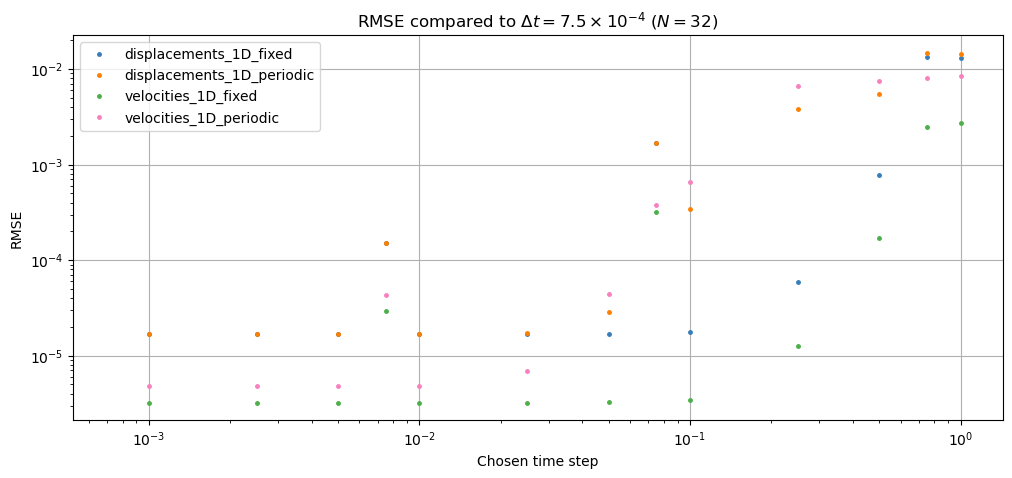

In [20]:
plot_rmse_series()


We note two anomalies corresponding to time steps $\Delta t = 0.075$ and at $\Delta t = 7.5 \times 10^{-3}$. It is likely that this error arose from unexpected behaviors of `scipy.interpolate` 1D interpolation function. Simiarly, we note that the errors for velocity data tends to be higher for larger time steps

Thus we chose $\Delta t = 0.025$ as our timestep

In [21]:
init_constants(mN_MODES = 5, mt_max = 1e3, mdt_mantissa = 2.5, mdt_exp = -2)

#   Simulate FPUT
displacements_1D_periodic, velocities_1D_periodic = oneD_simulator(rk4_step, initialize_n_mode,
                                                                   oneD_periodic, N, ALPHA, BETA, N_MODES, DT, TIME_POINTS)
displacements_1D_fixed, velocities_1D_fixed = oneD_simulator(rk4_step, initialize_n_mode,
                                                             oneD_fixed, N, ALPHA, BETA, N_MODES, DT, TIME_POINTS)


## Animation
The `gif_plotter` function visualizes the time evolution of vertical displacements in a simulated system by creating an animated GIF/MP4 that illustrates how displacements change over time

In [22]:
def gif_plotter(fn, displacements, config_str, dt, frame_step):
    """
    Creates an animation visualizing the time evolution of vertical displacements and
    saves it as an MP4 file

    Parameters:
    - fn:               Filename for the output video
    - displacements:    2D numpy array of displacements over time
    """
    fig, ax = plt.subplots()
    line, = ax.plot(displacements[0, :], marker = '.', markersize = 5, c = 'b')

    #   Set plot limits and labels
    ax.axhline(y = 0, c = '#d3d3d3', ls = '-', lw = 0.5)
    ax.axvline(x = displacements.shape[1] - 1, c = '#d3d3d3', ls = '-', lw = 0.5)
    ax.axvline(x = 0, c = '#d3d3d3', ls = '-', lw = 0.5)
    max = np.max(np.abs(displacements))
    ax.set_ylim(-max, max)
    ax.set_xlabel(r'$n^{\text{th}}$ Particle')
    ax.set_ylabel('Displacement (units)')
    title = ax.set_title(f'Time: {0:.3f} units')
    fig.suptitle(f'{fn} ({displacements.shape[1]} particles)')

    #   Update the y-data of the plot to show the displacements at the current time step
    def update(frame):
        """
        Update function for the animation
        """
        line.set_ydata(displacements[frame, :])
        title.set_text(f'Time: {frame * dt:.2f} units')
        return line, title

    #   Creates and saves animation
    ani = FuncAnimation(fig, update, frames = range(0, displacements.shape[0], frame_step),
                        blit = True)

    output_path = f'./{config_str}/{fn}_flat.mp4'
    ani.save(output_path, writer = 'ffmpeg', fps = 60)

    #   Close the plot
    plt.close()

    display(Video(output_path))
    return None

################################################################################
#                                                                              #
#                          ABOVE CODE USED FOR SET UP                          #
#                                                                              #
################################################################################

In [23]:
set_frame_step(displacements_1D_periodic.shape[0], 30)    #   30 frames
#   Plot animations
gif_plotter('displacements_1D_periodic', displacements_1D_periodic, CONFIG_STR, DT, FRAME_STEP)
gif_plotter('displacements_1D_fixed', displacements_1D_fixed, CONFIG_STR, DT, FRAME_STEP)


In [24]:
def circle_gif_plot(fn, displacements, config_str, dt, frame_step):
    """
    Creates a 3D animation visualizing the time evolution of vertical displacements around
    a circle, indicating periodic boundary conditions

    Parameters:
    - fn:               Filename for the output video
    - displacements:    2D numpy array of displacements over time
    """
    N = displacements.shape[1]
    thetas = np.linspace(0, 2 * PI, N + 1)
    x, y = np.cos(thetas), np.sin(thetas)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')
    scatter = ax.scatter(x[:-1], y[:-1], displacements[0, :], marker = '.', s = 5, c = 'b')
    line, = ax.plot(x, y, np.append(displacements[0, :], displacements[0, :][0]),
            marker = '.', markersize = 5, ls = '-', lw = 0.5, c = 'b')

    #   Set plot limits and labels
    max = np.max(np.abs(displacements))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zlim(-max, max)
    ax.set_zlabel('Displacement (units)')
    fig.suptitle(f'{fn} ({displacements.shape[1]} particles)')

    #   Update the y-data of the plot to show the displacements at the current time step
    def update(frame):
        """
        Update function for the animation
        """
        scatter._offsets3d = (x[:-1], y[:-1], displacements[frame, :])
        line.set_data_3d(x, y, np.append(displacements[frame, :], displacements[frame, 0]))
        ax.set_title(f'Time: {frame * dt:.3f} units')

        return scatter, line

    #   Creates and saves animation
    ani = FuncAnimation(fig, update, frames = range(0,displacements.shape[0], frame_step),
                                                    blit = True)

    output_path = f'./{config_str}/{fn}_circle.mp4'
    ani.save(output_path, writer = 'ffmpeg', fps = 60)

    #   Close the plot
    plt.close()

    display(Video(output_path))
    return None


In [25]:
def rotating_circle_gif_plot(fn, displacements, config_str, dt, frame_step):
    """
    Creates a rotating 3D animation visualizing the time evolution of vertical
    displacements around a circle, indicating periodic boundary conditions

    Parameters:
    - fn:               Filename for the output video without extension
    - displacements:    2D numpy array of displacements over time
    """
    N = displacements.shape[1]
    thetas = np.linspace(0, 2 * PI, N + 1)
    x, y = np.cos(thetas), np.sin(thetas)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')
    scatter = ax.scatter(x[:-1], y[:-1], displacements[0, :], marker = '.', s = 5, c = 'b')
    line, = ax.plot(x, y, np.append(displacements[0, :], displacements[0, :][0]),
            marker = '.', markersize = 5, ls = '-', lw = 0.5, c = 'b')

    #   Set plot limits and labels
    max = np.max(np.abs(displacements))
    ax.set_zlim(-max, max)
    ax.set_axis_off()
    ax.set_zlabel('Displacement (units)')
    ax.view_init(elev = 30, azim = 0)
    fig.suptitle(f'{fn} ({displacements.shape[1]} particles)')

    #   Update the y-data of the plot to show the displacements at the current time step
    def update(frame):
        """
        Update function for the animation to show displacement and rotation
        """
        scatter._offsets3d = (x[:-1], y[:-1], displacements[frame, :])
        line.set_data_3d(x, y, np.append(displacements[frame, :], displacements[frame, 0]))
        ax.azim = (frame // frame_step) % 360
        ax.set_title(f'Time: {frame * dt:.3f} units')

        return scatter, line

    #   Creates and saves animation
    ani = FuncAnimation(fig, update, frames = range(0,displacements.shape[0], frame_step),
                                                    blit = True)

    output_path = f'./{config_str}/{fn}_rotating.mp4'
    ani.save(output_path, writer = 'ffmpeg', fps = 60)

    #   Close the plot
    plt.close()

    display(Video(output_path))
    return None

################################################################################
#                                                                              #
#                          ABOVE CODE USED FOR SET UP                          #
#                                                                              #
################################################################################

In [26]:
set_frame_step(displacements_1D_periodic.shape[0], 30)    #   30 frames
circle_gif_plot('displacements_1D_periodic', displacements_1D_periodic, CONFIG_STR, DT, FRAME_STEP)
rotating_circle_gif_plot('displacements_1D_periodic', displacements_1D_periodic, CONFIG_STR, DT, FRAME_STEP)

## Total Energy
`potential_energy` and `kinetic_energy` calculate both the respective potential and kinetic energies at each time step and `total_energy_plotter` visualizes the total energy of the system over time

In [27]:
#   Calculates total potential energy at each time step
def potential_energy(displacements, mALPHA, mBETA):
    """
    Calculates the total potential energy at each time step for a system of particles

    Parameters:
    - displacements:    Numpy array of displacements at each time step (2D array)

    Returns:
    - total_pe:         Numpy array of total potential energy at each time step
    """
    delta_x = displacements - np.roll(displacements, -1, axis = 1)

    pe_linear = 0.5 * mALPHA * (delta_x ** 2)
    pe_nonlinear = (1/3) * mBETA * (delta_x ** 3)

    total_pe = np.sum(pe_linear + pe_nonlinear, axis = 1)

    return total_pe

In [28]:
#   Calculates total kinetic energy at each time step
def kinetic_energy(velocities):
    """
    Calculates the total kinetic energy at each time step for a system of particles

    Parameters:
    - velocities:   Numpy array of velocities at each time step (2D array)

    Returns:
    - total_ke:     Numpy array of total kinetic energy at each time step
    """
    ke = 0.5 * (velocities ** 2)

    total_ke = np.sum(ke, axis = 1)

    return total_ke

In [29]:
def total_energy_plotter(fn, displacements, velocities, mALPHA, mBETA, mtime_points, config_str):
    """
    Plots and saves a graph visualizing the total energy (potential + kinetic) of
    the system over time

    Parameters:
    - fn:               Filename for the saved plot
    - displacements:    Numpy array of displacements at each time step
    - velocities:       Numpy array of velocities at each time step
    """
    plt.figure(figsize = (12, 5))
    plt.stackplot(mtime_points, potential_energy(displacements[:-1], mALPHA, mBETA),
                  kinetic_energy(velocities[:-1]), labels = ['Potential Energy',
                                                             'Kinetic Energy'])

    #   Set plot limits and labels
    plt.grid(True)
    plt.xlabel('Time (units)')
    plt.ylabel('Total Energy')
    plt.legend()
    plt.title('Total Energy in the system over Time')
    plt.suptitle(f'{fn} ({displacements.shape[1]} particles)')

    #   Saves plot
    plt.savefig(f'./{config_str}/{fn}_total_energy.png', transparent = True)

    #   Show & close the plot
    plt.show()
    plt.close()
    return None

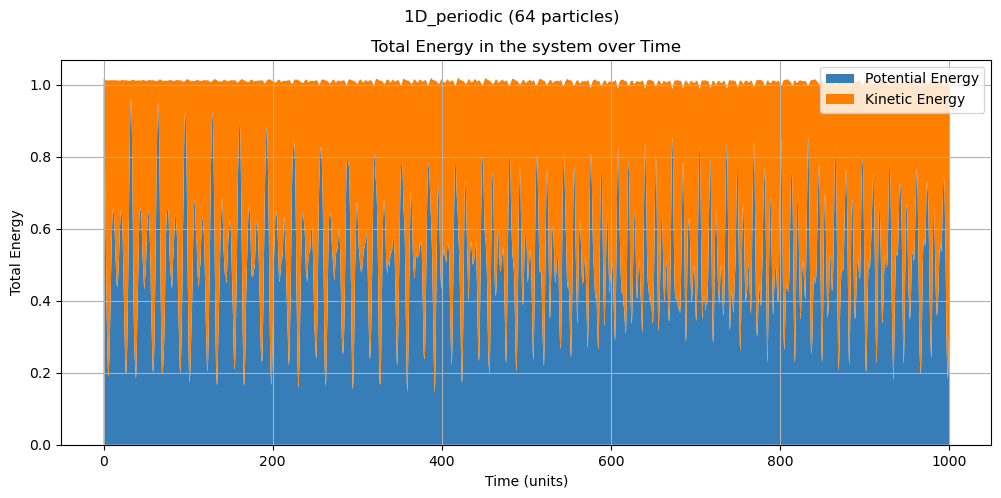

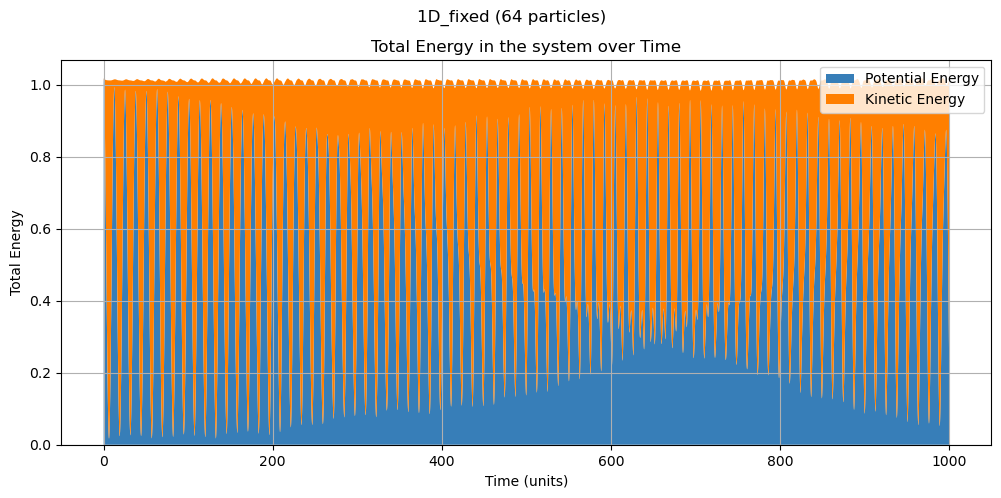

In [30]:
#   Plot total energy
total_energy_plotter('1D_periodic', displacements_1D_periodic, velocities_1D_periodic, ALPHA, BETA, TIME_POINTS, CONFIG_STR)
total_energy_plotter('1D_fixed', displacements_1D_fixed, velocities_1D_fixed, ALPHA, BETA, TIME_POINTS, CONFIG_STR)


## Mode Energy Analysis
`fft_plotter` analyzes the energy distribution across different modes in a system over time by using the Fast Fourier Transform (FFT)

In [31]:
def fft_plotter(fn, displacements, time_points, config_str):
    """
    Plots and saves a graph visualizing the energy distribution across the first four
    FFT modes of displacements over time

    Parameters:
    - fn:               Filename for the saved plot, excluding file extension
    - displacements:    2D numpy array of displacements at each time step
    """
    # Perform the Fourier Transform on displacements
    fourier_transform = np.fft.rfft(displacements[:-1], axis = 1)
    mode_energies = np.abs(fourier_transform) ** 2

    plt.figure(figsize = (12, 5))
    for i in range(1, 5):  # First four modes after the zero mode
        plt.plot(time_points, mode_energies[:, i], ls = '-', lw = 0.5, label = f'Mode {i}')

    #   Set plot limits and labels
    plt.grid(True)
    plt.xlabel('Time (units)')
    plt.ylabel('Mode Energy')
    plt.legend()
    plt.title('Energy in the First Four Modes Over Time')
    plt.suptitle(f'{fn} ({displacements.shape[1]} particles)')

    #   Saves plot
    plt.savefig(f'./{config_str}/{fn}_energy_modes.png', transparent = True)

    #   Show & close the plot
    plt.show()
    plt.close()
    return None

################################################################################
#                                                                              #
#                          ABOVE CODE USED FOR SET UP                          #
#                                                                              #
################################################################################

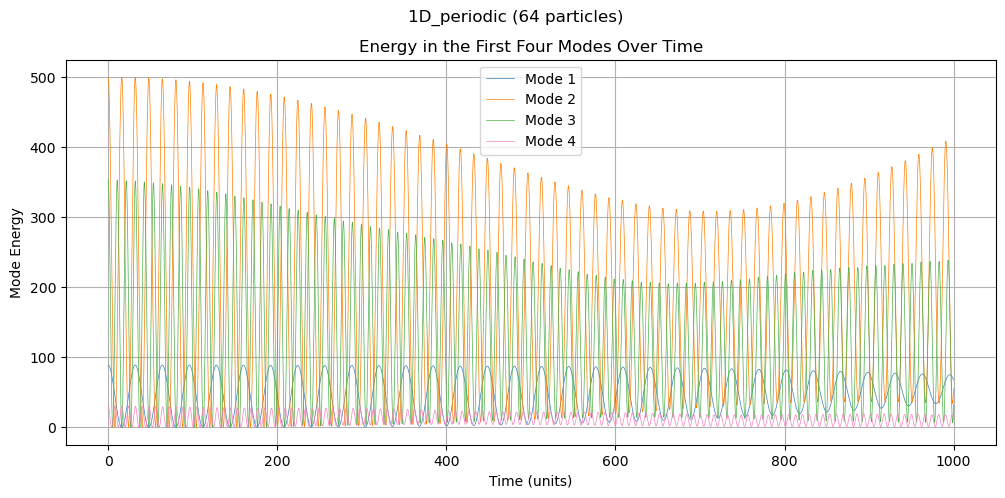

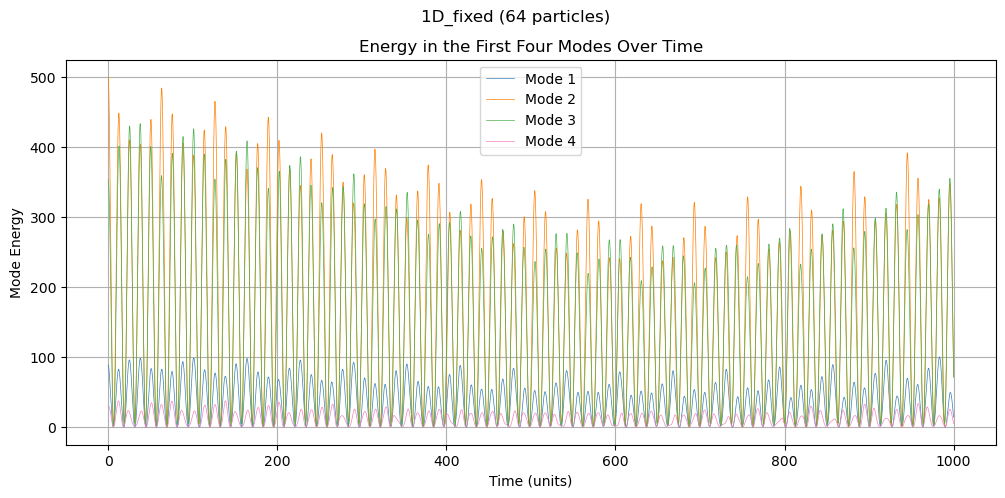

In [32]:
#   Plot FFT
fft_plotter('1D_periodic', displacements_1D_periodic, TIME_POINTS, CONFIG_STR)
fft_plotter('1D_fixed', displacements_1D_fixed, TIME_POINTS, CONFIG_STR)


# Custom Plots

In [33]:
# for i in range(1, 11):
#     init_constants(mN = 2 ** 7, mN_MODES = i, mt_max = 1e3)
#     d1p, v1p = oneD_simulator(rk4_step, initialize_n_mode, oneD_periodic, N, ALPHA, BETA, N_MODES, DT, TIME_POINTS)
#     set_frame_step(d1p.shape[0], 30)
#     rotating_circle_gif_plot('displacements_1D_periodic', d1p, CONFIG_STR, DT, FRAME_STEP)
    

In [36]:
def custom_gif_plotter(fn, d1, d2, config_str, frame_step, dt):
    """
    Creates an animation visualizing the time evolution of vertical displacements and
    saves it as an MP4 file

    Parameters:
    - fn:               Filename for the output video
    - displacements:    2D numpy array of displacements over time
    """
    fig, ax = plt.subplots()
    line1, = ax.plot(d1[0, :], marker = '.', markersize = 5, ls = '-', lw = 0.5, label = 'linear')
    line2, = ax.plot(d2[0, :], marker = '.', markersize = 5, ls = '-', lw = 0.5, label = 'non-linear')

    #   Set plot limits and labels
    max = np.max(np.abs(np.append(d1, d2)))
    ax.set_ylim(-max, max)
    ax.legend(loc = 'lower right')
    ax.grid(True)
    ax.set_xlabel(r'$n^{\text{th}}$ Particle')
    ax.set_ylabel('Displacement (units)')
    title = ax.set_title(f'Time: {0:.3f} units')
    fig.suptitle(f'{fn} ({d1.shape[1]} particles)')

    #   Update the y-data of the plot to show the displacements at the current time step
    def update(frame):
        """
        Update function for the animation
        """
        line1.set_ydata(d1[frame, :])
        line2.set_ydata(d2[frame, :])
        title.set_text(f'Time: {frame * dt:.2f} units')
        return line1, line2, title

    #   Creates and saves animation
    ani = FuncAnimation(fig, update, frames = range(0, d1.shape[0], frame_step),
                        blit = True)

    output_path = f'./{config_str}/{fn}_flat.mp4'
    ani.save(output_path, writer = 'ffmpeg', fps = 60)

    #   Close the plot
    plt.close()

    display(Video(output_path))
    return None

################################################################################
#                                                                              #
#                          ABOVE CODE USED FOR SET UP                          #
#                                                                              #
################################################################################

In [37]:
#   Simulate linear
init_constants(mN = 64, mBETA = 0, mN_MODES = 3, mt_max = 1e3)
displacements_linear_custom, velocities_linear_custom = oneD_simulator(rk4_step, initialize_n_mode, oneD_fixed,
                                                                       N, ALPHA, BETA, N_MODES, DT, TIME_POINTS)

#   Simulate nonlinear
init_constants(mN = 64, mBETA = 0.1, mN_MODES = 3, mt_max = 1e3)
displacements_non_linear_custom, velocities_non_linear_custom = oneD_simulator(rk4_step, initialize_n_mode, oneD_fixed,
                                                                                  N, ALPHA, BETA, N_MODES, DT, TIME_POINTS)

set_frame_step(displacements_linear_custom.shape[0], 30)    #   30 frames
#   Plot animations
custom_gif_plotter('linear_vs_nonlinear', displacements_linear_custom, displacements_non_linear_custom, CONFIG_STR, FRAME_STEP, DT)
